# Load the data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
data_dir = Path("data")

X_test = data_dir / "X_test.csv"
y_train = data_dir / "y_train.csv"
X_train = data_dir / "X_train.csv"

X_test = pd.read_csv(X_test, index_col="id")
X_test.index = X_test.index.astype(int)

y_train = pd.read_csv(y_train, index_col="id")
y_train.index = y_train.index.astype(int)

X_train = pd.read_csv(X_train, index_col="id")
X_train.index = X_train.index.astype(int)

print(f"X_train.shape {X_train.shape}, y_train.shape {y_train.shape}, X_test.shape {X_test.shape}")

print(X_train.head())

X_train.shape (1212, 832), y_train.shape (1212, 1), X_test.shape (776, 832)
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554           NaN  4101.016273   92959.527633         NaN   
2   14226.656663  11029.642499          NaN  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892           NaN  10492.342868           NaN  10.810076  ...   
3   101.929026  10050.049

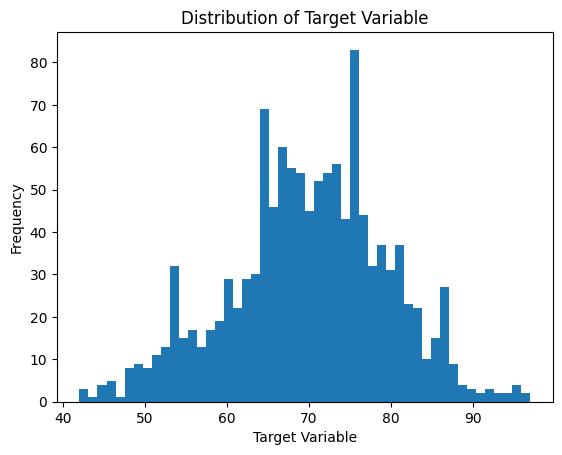

In [2]:
#have a look at the data
import matplotlib.pyplot as plt
plt.hist(y_train.values, bins=50)
plt.xlabel("Target Variable")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.show()


# 1. imputing missing values

First we impute nan values with the mean for each feature

In [3]:
X_train.fillna(pd.Series(X_train.mean()), inplace=True)
print(f"Nan-values: {X_train.isna().sum().sum()}")
print(X_train.head())
X_test.fillna(pd.Series(X_test.mean()), inplace=True)
y_train.fillna(pd.Series(y_train.mean()), inplace=True)

Nan-values: 0
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554  10950.160761  4101.016273   92959.527633  105.070358   
2   14226.656663  11029.642499  3430.837498  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892   9983.055476  10492.342868  10495.835570  10.810076  ...   
3   101.929026  10050.049932  10499.521099  10525.030989  10.092109  ...   
4    95.789

# 2. Outlier detection
Next we build an outlier detection model to classify samples as outliers and eventually remove them

In [4]:
#outlier detection using isolation forest and guessing the contamination to be 5%

from sklearn.ensemble import IsolationForest
outlier_model = IsolationForest(contamination=0.05, random_state=42)
outlier_model.fit(X_train)
outlier_preds = outlier_model.predict(X_train)
isoforest_outlier_indices = set(np.where(outlier_preds == -1)[0])

print("Outlier indices:", isoforest_outlier_indices)

print(f"Number of outliers detected: {len(isoforest_outlier_indices)}")

Outlier indices: {np.int64(3), np.int64(515), np.int64(645), np.int64(900), np.int64(1031), np.int64(648), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(24), np.int64(1048), np.int64(30), np.int64(416), np.int64(1056), np.int64(1058), np.int64(805), np.int64(167), np.int64(297), np.int64(681), np.int64(428), np.int64(306), np.int64(821), np.int64(694), np.int64(697), np.int64(953), np.int64(573), np.int64(190), np.int64(575), np.int64(64), np.int64(321), np.int64(448), np.int64(837), np.int64(70), np.int64(583), np.int64(75), np.int64(460), np.int64(972), np.int64(1102), np.int64(335), np.int64(474), np.int64(91), np.int64(731), np.int64(860), np.int64(991), np.int64(480), np.int64(225), np.int64(1120), np.int64(100), np.int64(229), np.int64(740), np.int64(231), np.int64(234), np.int64(362), np.int64(1137), np.int64(114), np.int64(882), np.int64(502), np.int64(1144), np.int64(506), np.int64(1150)}
Number of outliers detected: 61


In [5]:
# outlier detection using OneClassSVM

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
svm_model.fit(X_train_scaled)
svm_preds = svm_model.predict(X_train_scaled)

print("SVM Outlier indices:", np.where(svm_preds == -1)[0])

svm_outlier_indices = set(np.where(svm_preds == -1)[0])

print(f"Number of outliers detected by SVM: {np.sum(svm_preds == -1)}")

# Comparing the two methods
common_outliers = isoforest_outlier_indices & svm_outlier_indices
print(f"Number of common outliers detected by both methods: {len(common_outliers)}")
print("Common outlier indices:", common_outliers)

SVM Outlier indices: [  16   30   32   56   70   72   88   91  142  168  180  207  211  214
  245  278  313  321  334  352  397  403  404  431  518  537  545  553
  570  574  583  616  622  631  633  635  681  694  731  732  741  755
  771  805  806  808  836  872  882  888  899  900  906  917  949  953
  972  990  994 1001 1038 1066 1081 1087 1102 1132 1135 1144 1205]
Number of outliers detected by SVM: 69
Number of common outliers detected by both methods: 19
Common outlier indices: {np.int64(900), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(30), np.int64(805), np.int64(681), np.int64(694), np.int64(953), np.int64(321), np.int64(70), np.int64(583), np.int64(972), np.int64(1102), np.int64(731), np.int64(91), np.int64(882), np.int64(1144)}


In [6]:
#removing outliers from the training data
X_train_cleaned = X_train.drop(index=X_train.index[list(common_outliers)])
y_train_cleaned = y_train.drop(index=y_train.index[list(common_outliers)])
print(f"Cleaned X_train shape: {X_train_cleaned.shape}, Cleaned y_train shape: {y_train_cleaned.shape}")

Cleaned X_train shape: (1193, 832), Cleaned y_train shape: (1193, 1)


# 3. Feature selection
In order to perform a useful regression we need to select features suitable for the age prediction

In [7]:

def correlation_matrix_reduction():
    corr_matrix = X_train_cleaned.corr().abs()  # absolute value

    # Mask upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation > threshold
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    print("Highly correlated features to drop:", to_drop)
    print(f"Number of features to drop: {len(to_drop)}")
    return to_drop

# Feature selection

this step is harder than imagined, a new idea came to my mind:

1: select a subset of features randomly, train and score the predictions, as well as the features used

2: do it for another subset

3: mark the features which occur in higher scored subsets and use these for the final training (Monte Carlo aproach)

In [8]:
from subset_selector import RandomSubsetSelector
from xgboost import XGBRegressor

selector = RandomSubsetSelector(
    estimator=XGBRegressor(
        n_estimators=100,      # Number of trees; start low for speed in subset selection
        max_depth=4,           # Tree depth; controls complexity
        learning_rate=0.05,     # Step size; balances speed and accuracy
        subsample=0.6,         # Fraction of samples per tree; adds randomness
        colsample_bytree=0.6,  # Fraction of features per tree; helps with high-dimensional data
        random_state=42,       # For reproducibility
        n_jobs=-1              # Use all cores
    ),
    n_trials=1200,          # more trials → better coverage
    subset_frac=0.02,
    cv=4,
    top_k=400,
    n_jobs=-1,
    verbose=True,
    random_state=42,
    max_samples=300,
)
load_cached = True

filename = Path("feature_selection") / "random_subset_selector_features.csv"
if not load_cached:
    X_selected = selector.fit_transform(X_train_cleaned, y_train_cleaned, feature_names=X_train_cleaned.columns)
    with open(filename, "w") as f:
        for feature in selector.selected_features_:
            f.write(f"{feature}\n")
    print("\n=== Top-10 most frequent features in best subsets ===")
    print(selector.summary.head(20))
    print(f"Selected feature set shape: {X_selected.shape}")
else:
    with open(filename, "r") as f:
        cols = [line.strip() for line in f.readlines()]
    X_selected = X_train_cleaned[cols]



# Main Task, fit a model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

activation = nn.Sigmoid

# Define a simple MLP module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units=128, num_layers=2, dropout=0.2):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, hidden_units), activation(), nn.Dropout(dropout)]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_units, hidden_units), activation(), nn.Dropout(dropout)])
        layers.append(nn.Linear(hidden_units, 1))  # Regression output
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [20]:
# === MULTI-MODEL COMPARISON FOR BRAIN MRI AGE PREDICTION ===

from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# --- 1. Split (keep X_selected from RandomSubsetSelector) ---
X_train, X_t, y_train, y_t = train_test_split(
    X_selected, y_train_cleaned, test_size=0.15, random_state=42
)

X_train = X_train.astype(np.float32).values
X_t = X_t.astype(np.float32).values
y_train = y_train.astype(np.float32).values
y_t = y_t.astype(np.float32).values

# --- 2. CV Strategy ---
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
scorer = make_scorer(r2_score, greater_is_better=True)

good_model = {
    "XGBoost": {
        "model": XGBRegressor(random_state=35, n_jobs=-1),
        "params": {
            "model__n_estimators": [500],
            "model__max_depth": [5,], 
            "model__learning_rate": [0.02],
            "model__subsample": [0.8],
            "model__colsample_bytree": [0.7],
            "model__gamma": [1],
            "model__reg_alpha": [0.1],
        },
        "needs_scaling": True
    },
}


# --- 3. Models & Hyperparameter Grids ---
models = {
    "TorchNN": {
            "model": NeuralNetRegressor(
                module=MLP,
                module__input_dim=X_selected.shape[1],
                criterion=nn.MSELoss,
                optimizer=optim.Adam,
                max_epochs=200,
                batch_size=32,
                device='cuda' if torch.cuda.is_available() else 'cpu',  # GPU if available
                callbacks=[EarlyStopping(monitor='valid_loss', patience=30, threshold=0.0001)],
                verbose=0,
            ),
            "params": {
                "model__module__hidden_units": [32, 64, 128, 256, 512],  # Neurons per layer
                "model__module__num_layers": [2, 3, ],         # Depth
                "model__module__dropout": [0.3, 0.5, 0.7],      # Regularization
                "model__optimizer__lr": [0.001, 0.005], # Learning rate
                "model__max_epochs": [200, 400, 600, ],           # Training epochs
                "model__batch_size": [16, 32]               # Batch size
            },
            "needs_scaling": True
        },
}

# --- 4. Train & Compare ---
results = []

for name, config in models.items():
    print(f"\nTraining {name}...")
    
    # Build pipeline
    steps = []
    if config["needs_scaling"]:
        steps.append(("scaler", StandardScaler()))
    steps.append(("model", config["model"]))
    pipe = Pipeline(steps)
    
    # Grid search
    gs = RandomizedSearchCV(
        pipe, config["params"], cv=cv, scoring=scorer, n_jobs=-1, verbose=1
    )

    gs.fit(X_train, y_train)
    
    # Predict
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_t)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_t, y_test_pred)
    test_mae = mean_absolute_error(y_t, y_test_pred)
    
    results.append({
        "Model": name,
        "Best R² (CV)": gs.best_score_,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Test MAE": test_mae,
        "Best Params": gs.best_params_
    })

    print(f"→ {name} | CV R²: {gs.best_score_:.4f} | Test R²: {test_r2:.4f} | Test MAE: {test_mae:.4f}")

# --- 5. Results Table ---
results_df = pd.DataFrame(results).round(4)
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(results_df[["Model", "Best R² (CV)", "Train R²", "Test R²", "Test MAE"]].to_string(index=False))
print(results_df[["Best Params"]].to_string(index=False))


Training TorchNN...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
→ TorchNN | CV R²: 0.4311 | Test R²: 0.4428 | Test MAE: 5.1363

FINAL MODEL COMPARISON
  Model  Best R² (CV)  Train R²  Test R²  Test MAE
TorchNN        0.4311    0.5286   0.4428    5.1363
                                                                                                                                                                          Best Params
{'model__optimizer__lr': 0.001, 'model__module__num_layers': 3, 'model__module__hidden_units': 128, 'model__module__dropout': 0.5, 'model__max_epochs': 400, 'model__batch_size': 32}


# Train the model once again on the full dataset for the public test

In [ ]:
def final_training(model):
    params = results_df[["Best Params"]].iloc[0].values[0]
    print(params)
    model = model(**params)
    model.fit(X_selected, y_train_cleaned)
    return model

# Save the test results for online evaluation

In [ ]:
from datetime import datetime

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)


def save_test_predictions(model, model_name):
    model = final_training(model)
    save_path = results_dir / f"test_{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

    y_test_pred = model.predict(X_test[X_selected.columns])
    results_df = pd.DataFrame(y_test_pred, index=X_test.index, columns=["y"])
    assert (results_df.shape == (776, 1)), f"Unexpected shape: {results_df.shape}"
    results_df.to_csv(save_path)
    print(f"Test predictions saved to {save_path}")

save_test_predictions(XGBRegressor, "xgboost")

'kaggle competitions submit -c eth-aml-2025-project-1 -f submission.csv -m "Message"'

{'model__learning_rate': 0.02, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.8}


c:\conda\envs\LRF\lib\site-packages\xgboost\training.py:199: UserWarning: [00:19:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test predictions saved to results\test_xgboost_20251030_001918.csv


'kaggle competitions submit -c eth-aml-2025-project-1 -f submission.csv -m "Message"'